In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from shapely.geometry import Point
import geopandas as gpd
import geopandas as gp
import hdbscan
import contextily as ctx


import warnings
warnings.filterwarnings('ignore')


In [2]:
# TASK 1
df=pd.read_csv('uber-raw-data-jun14.csv',nrows=100000)         
print(df.shape)
df.head()

(100000, 4)


,Date/Time,Lat,Lon,Base
0,6/1/2014 0:00:00,40.7293,-73.9920,B02512
1,6/1/2014 0:01:00,40.7131,-74.0097,B02512
2,6/1/2014 0:04:00,40.3461,-74.6610,B02512
3,6/1/2014 0:04:00,40.7555,-73.9833,B02512
4,6/1/2014 0:07:00,40.6880,-74.1831,B02512


In [3]:
df = gp.GeoDataFrame(df, geometry=gp.points_from_xy(df.Lon, df.Lat))
df.head()

,Date/Time,Lat,Lon,Base,geometry
0,6/1/2014 0:00:00,40.7293,-73.9920,B02512,POINT (-73.99200 40.72930)
1,6/1/2014 0:01:00,40.7131,-74.0097,B02512,POINT (-74.00970 40.71310)
2,6/1/2014 0:04:00,40.3461,-74.6610,B02512,POINT (-74.66100 40.34610)
3,6/1/2014 0:04:00,40.7555,-73.9833,B02512,POINT (-73.98330 40.75550)
4,6/1/2014 0:07:00,40.6880,-74.1831,B02512,POINT (-74.18310 40.68800)


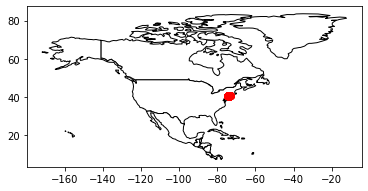

In [4]:
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
ax = world[world.continent == 'North America'].plot(color='white', edgecolor='black')
df.plot(ax=ax, color='red')
plt.show()

In [5]:
# TASK 2
df1=df[['Lat','Lon']]
df1

,Lat,Lon
0,40.7293,-73.9920
1,40.7131,-74.0097
2,40.3461,-74.6610
3,40.7555,-73.9833
4,40.6880,-74.1831
...,...,...
99995,40.7661,-73.9950
99996,40.7178,-73.9926
99997,40.6810,-73.9711
99998,40.7495,-73.9754


In [6]:
model = StandardScaler()
df_scaled = model.fit_transform(df1)
df_std = pd.DataFrame(df_scaled, columns=df1.columns)
df_std

,Lat,Lon
0,-0.319105,-0.289557
1,-0.730854,-0.588585
2,-10.058756,-11.591787
3,0.346811,-0.142578
4,-1.368811,-3.518042
...,...,...
99995,0.616227,-0.340240
99996,-0.611396,-0.299694
99997,-1.546728,0.063532
99998,0.194311,-0.009113


In [7]:
# TASK 3
cluster_size = [30,40,50,60,70,100,200,300]

for i in cluster_size:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=i, gen_min_span_tree=True)
    clusterer.fit(df_std)
    df_std[f"{'Cluster',i}"]=clusterer.labels_

In [8]:
df_std

,Lat,Lon,"('Cluster', 30)","('Cluster', 40)","('Cluster', 50)","('Cluster', 60)","('Cluster', 70)","('Cluster', 100)","('Cluster', 200)","('Cluster', 300)"
0,-0.319105,-0.289557,242,394,76,42,301,58,25,10
1,-0.730854,-0.588585,-1,410,286,34,18,21,11,26
2,-10.058756,-11.591787,-1,-1,-1,0,0,-1,-1,-1
3,0.346811,-0.142578,463,225,157,312,217,128,104,55
4,-1.368811,-3.518042,5,197,11,16,15,7,83,11
...,...,...,...,...,...,...,...,...,...,...
99995,0.616227,-0.340240,-1,410,286,34,18,21,11,26
99996,-0.611396,-0.299694,-1,410,286,34,18,21,11,26
99997,-1.546728,0.063532,72,69,207,224,239,143,78,60
99998,0.194311,-0.009113,437,241,120,300,176,159,108,56


In [9]:
df_std["('Cluster', 30)"].nunique()

490

In [10]:
ncluster = []

for i in cluster_size:
    x = df_std[f"{'Cluster',i}"].nunique()
    ncluster.append(x)
ncluster

[490, 414, 370, 330, 314, 248, 138, 85]

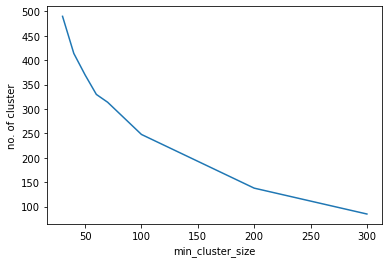

In [11]:
plt.plot(cluster_size,ncluster)
plt.xlabel('min_cluster_size')
plt.ylabel('no. of cluster')
plt.show()

In [13]:
noutliers = []

for i in cluster_size:
    x = df_std[df_std[f"{'Cluster',i}"] == -1][f"{'Cluster',i}"].count()
    noutliers.append(x)
noutliers

[44655, 5069, 420, 251, 307, 1135, 3102, 5253]

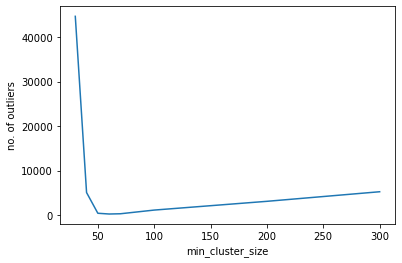

In [14]:
plt.plot(cluster_size,noutliers)
plt.xlabel('min_cluster_size')
plt.ylabel('no. of outliers')
plt.show()

In [15]:
# TASK 4
clusterer = hdbscan.HDBSCAN(min_cluster_size=70).fit(df1)
Label = clusterer.labels_                                     
Label

array([31, 31, -1, ..., 30, 31, 31], dtype=int64)

In [16]:
Label_df =pd.DataFrame(Label, columns=['Cluster'])
new_df = pd.concat([df1,Label_df],axis=1)
new_df

,Lat,Lon,Cluster
0,40.7293,-73.9920,31
1,40.7131,-74.0097,31
2,40.3461,-74.6610,-1
3,40.7555,-73.9833,31
4,40.6880,-74.1831,1
...,...,...,...
99995,40.7661,-73.9950,31
99996,40.7178,-73.9926,31
99997,40.6810,-73.9711,30
99998,40.7495,-73.9754,31


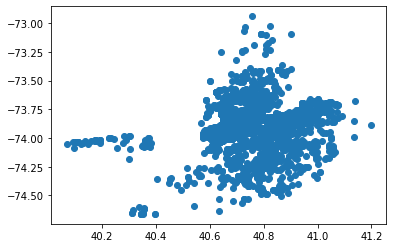

In [17]:
outlier1 = new_df[new_df['Cluster'] == -1]
plt.scatter(outlier1.iloc[:,0],outlier1.iloc[:,1])
plt.show()

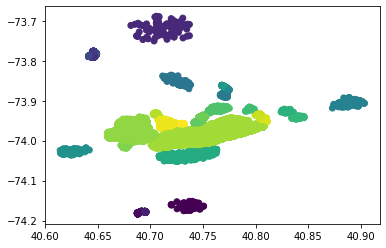

In [18]:
cluster1 = new_df[new_df['Cluster'] != -1]
plt.scatter(cluster1.iloc[:,0],cluster1.iloc[:,1], c=cluster1.Cluster)
plt.show()

In [16]:
# TASK 5
clusterer = hdbscan.HDBSCAN(min_cluster_size=70).fit(df_scaled)

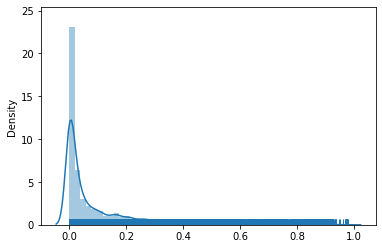

In [17]:
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)
plt.show()

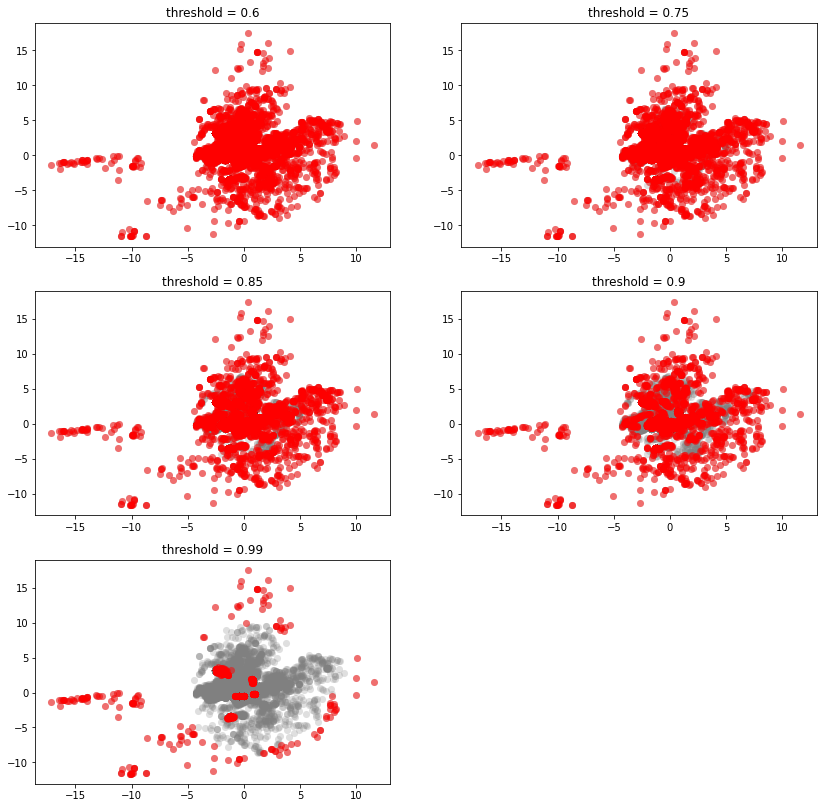

In [18]:
c=1
fig = plt.figure(figsize=(14,14))
for quant in [0.6,0.75, 0.85, 0.9,0.99]:
    plt.subplot(3, 2, c)
    plt.title('threshold = '+ str(quant))
    threshold = pd.Series(clusterer.outlier_scores_).quantile(quant)
    outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
    plt.scatter(*df_scaled.T, s=50, linewidth=0, c='gray', alpha=0.25)
    plt.scatter(*df_scaled[outliers].T, s=50, linewidth=0, c='red', alpha=0.5)
    c=c +1
    